# Digital Image Processing and Analysis Using PIL

In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Reading and processing data
- Read raster file into a PIL image object
- Seperate bands and convert each to an array
- Stack bands to create an RGB composite, then convert back to PIL image object for further processing

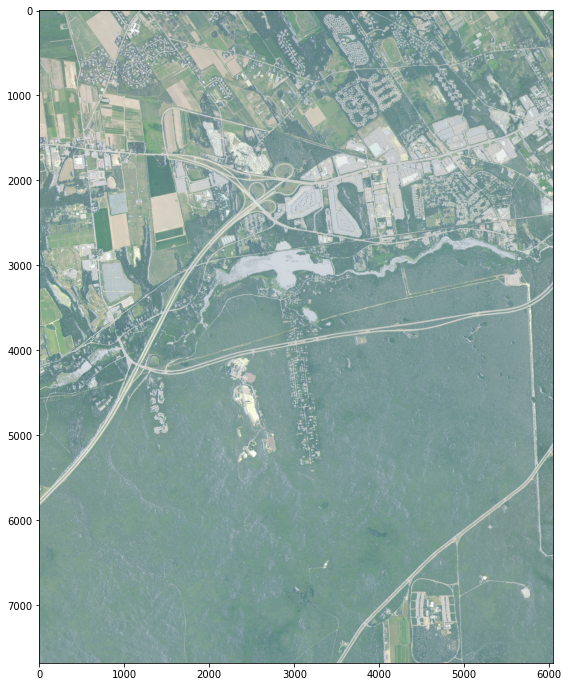

In [3]:
pil_image = Image.open('./data/m_4007203_sw_18_1_20170809/SflkPineForest.tif')
# set the runtime configuration for matplot lib (default parameters)
plt.rcParams['figure.figsize'] = 16, 12
rgbnir_array = np.array(pil_image)
# plt.figure(figsize=(16,12))
plt.imshow(pil_image)

In [4]:
# Split image file into seperate bands
r_pil, g_pil, b_pil, nir_pil = Image.Image.split(pil_image)

In [5]:
# Convert PIL image objects to array
r_array = np.array(r_pil)
g_array = np.array(g_pil)
b_array = np.array(b_pil)
nir_array = np.array(nir_pil)

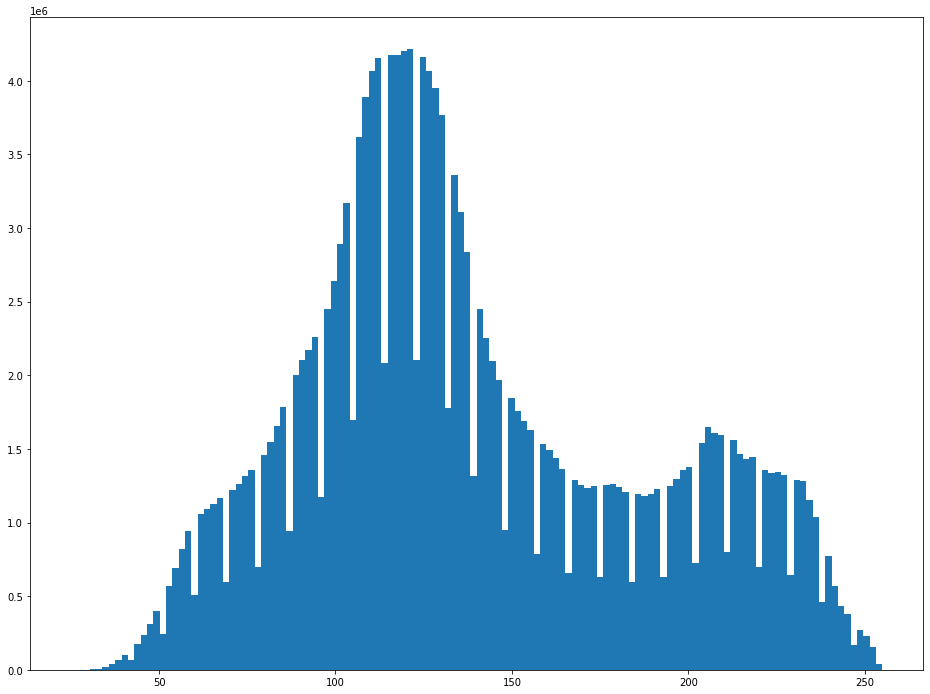

In [28]:
# plot histogram
plt.hist(rgbnir_array.flatten(), 128)
plt.show()

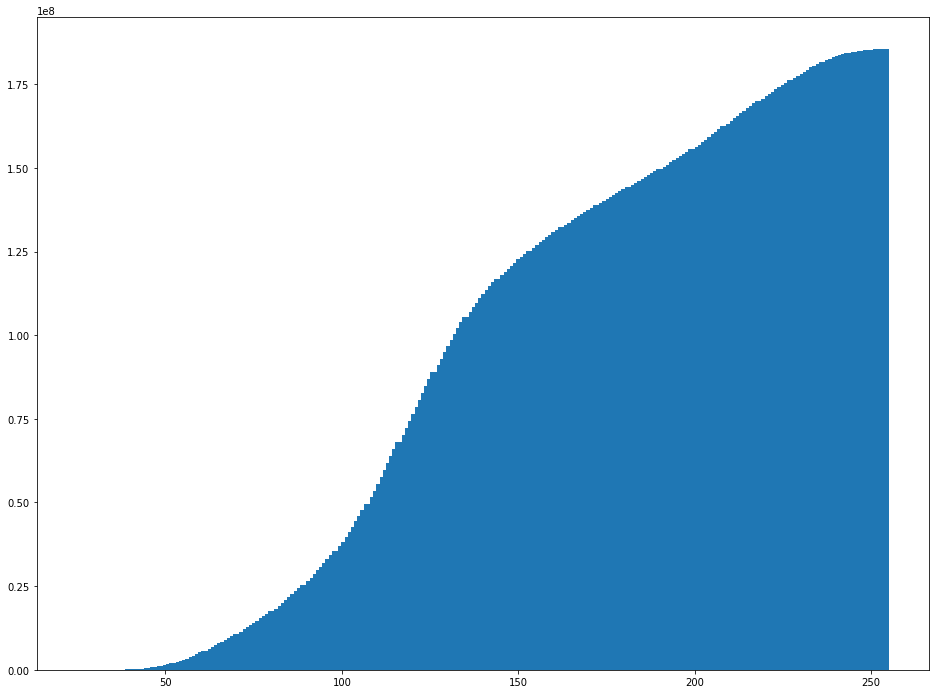

In [26]:
# plot cumuulative frequency distribution
plt.hist(rgbnir_array.flatten(), bins = 255, cumulative=True)
plt.show()

In [8]:
# create an rgb composite by using numpy dstack function
rgb_array = np.dstack((r_array,g_array,b_array))
print(rgb_array.shape)

(7677, 6046, 3)


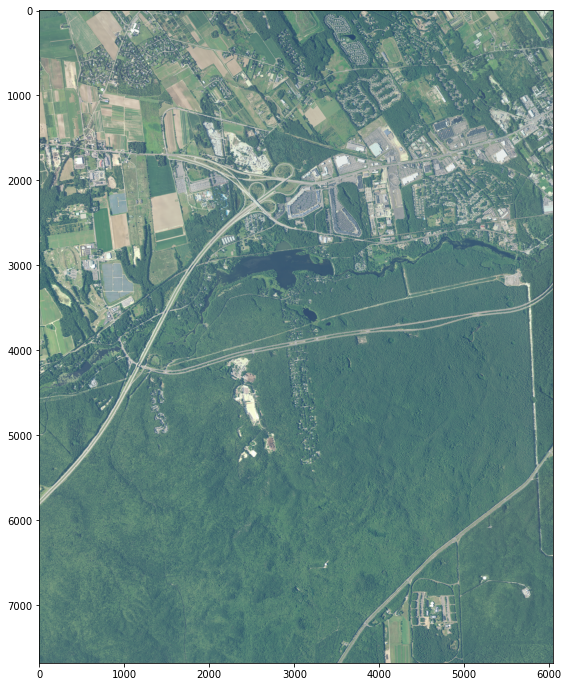

In [9]:
plt.imshow(rgb_array)

### Convert the stack array to a PIL image object
__Convert the stacked array to a PIL image object__

PIL.Image.Image

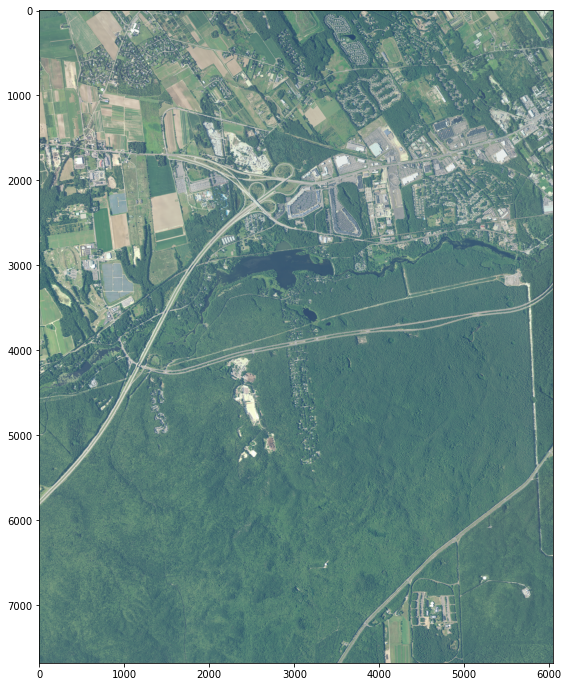

In [10]:
# Convert the stacked array to a PIL image object
# You can apply image operations on the image object (PIL.Image.open() also returns an image object)
rgb_pil = Image.fromarray(rgb_array)
plt.imshow(rgb_pil)
type(rgb_pil)

## View PIL Image Object Meta Data

In [10]:
# Check size and dimensions
print(rgb_array.shape) # rememeber, array index is row, col, band
print(rgb_pil.size) # index is band, col in PIL image

(7677, 6046, 3)
(6046, 7677)


In [22]:
print(rgb_pil.getbands())
print(rgb_pil.format)

('R', 'G', 'B')
None


## Clipping Image and Merging Bands

The image class contains methods allowing you to manipulate regions within an image. To extract a sub-rectangle from an image, use the crop() method ([from PIL documentation](https://pillow.readthedocs.io/en/5.1.x/handbook/tutorial.html)).

In [23]:
# The region is defined by a 4-tuple, where coordinates are (xmin, ymax, xmax, ymin) or (left, upper, right, lower)
# The Python Imaging Library uses a coordinate system with (0, 0) in the upper left corner
box = (2100, 3900, 2900, 5600)
region = rgb_pil.crop(box)

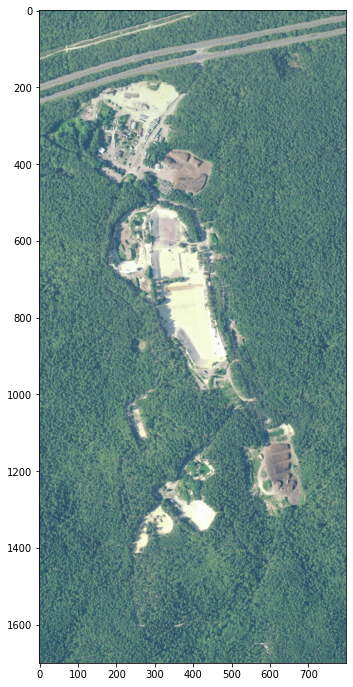

In [24]:
plt.imshow(region)

The region could now be processed in a certain manner and pasted back.

### Processing a region and pasting it back to the original image

__Point Operations__
- The point( ) method maps an image through a lookup table or function. It can be used to translate the pixel values of an image (e.g. image contrast manipulation). 

In [26]:
# Use the point method to map all the cells in the region through a function,
# then paste the new values back onto the original image
box = (2100, 3900, 2900, 5600)
region = rgb_pil.crop(box)

out = region.point(lambda i: i * 1.3)
rgb_pil.paste(out, box)

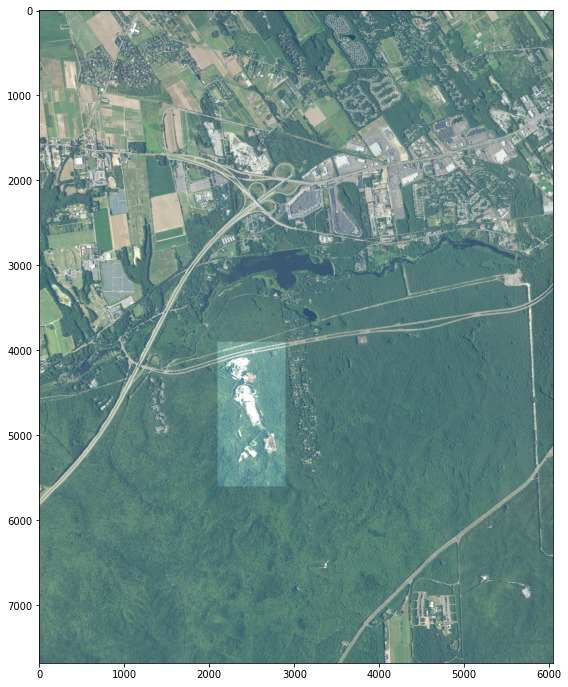

In [27]:
plt.imshow(rgb_pil)

### Splitting and merging bands
- Split the image into seperate bands
- Processing the image:
> - Create a boolean mask by selecting regions where red is less than 100 (high absorption)
> - Process each pixel in the green band by using the point() method
> - Paste the processed green band back into the original image, but only where red was < 100 (using the red band mask)

In [20]:
# Read in the rgb array into a PIL image object
rgb_pil = Image.fromarray(rgb_array)

# split the image into individual bands (creates a tuple stored with image objects for each band)
source = rgb_pil.split()

R, G, B = 0, 1, 2 # for indexing the source variable

# select regions where red is less than 100
mask = source[R].point(lambda i: i < 100 and 255)

# process the green band
out = source[G].point(lambda i: i * 0.7)

# paste the processed band back, but only where red was < 100
source[G].paste(out, None, mask)

# build a new multiband image
im = Image.merge(rgb_pil.mode, source)

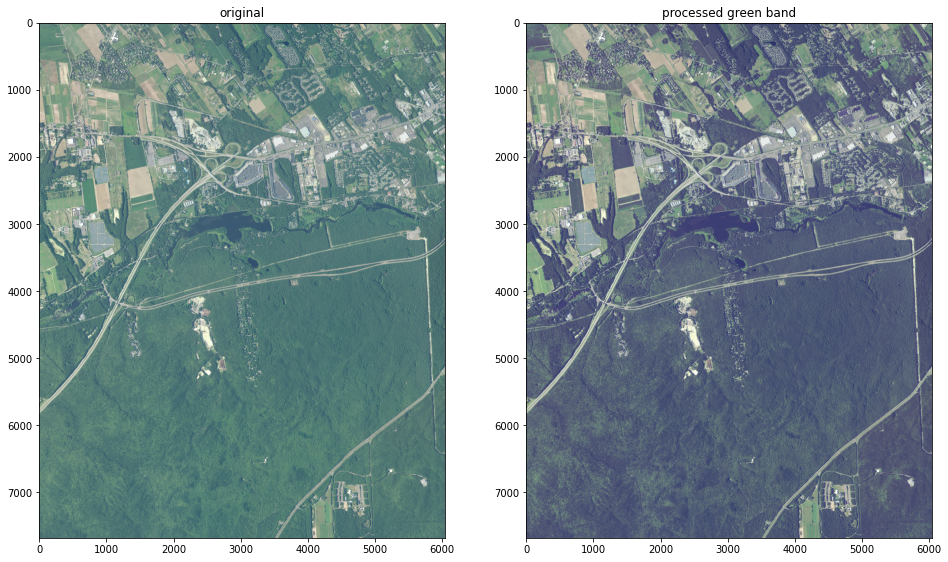

In [21]:
# Display the original RGB and newly processed composite for quick visualization purposes

fig=plt.figure(figsize=(16,12))

# display rgb
a = fig.add_subplot(1,2,1)
rgb_plot = plt.imshow(rgb_pil)
a.set_title('original')

# display processed green band
a = fig.add_subplot(1,2,2)
newRGB_plot = plt.imshow(im)
a.set_title('processed green band')

plt.show()

## Image Enhancement
Enhancing image, such as contrast stretching, allows us to better identify features.
- Contrast stretching (often called normalization) is a simple image enhancement technique that attempts to improve the contrast in an image by 'stretching' the range of intensity values it contains to span a desired range of values. Contrast stretching is restricted to a linear mapping of input to output values. The result is less dramatic than histogram equalization, but tends to avoid the sometimes artificial appearance of equalized images.
- Histogram equalization employs non-linear mapping which re-assigns the intensity values of pixels in the input image so that the output image contains a uniform distribution of intensities (i.e. a flat histogram). This technique is used in image comparison processes (because it is effective in detail enhancement).

[Reference1](https://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm#:~:text=Contrast%20stretching%20(often%20called%20normalization,the%20image%20type%20concerned%20allows)

[Reference2](https://academic.mu.edu/phys/matthysd/web226/Lab01.htm)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


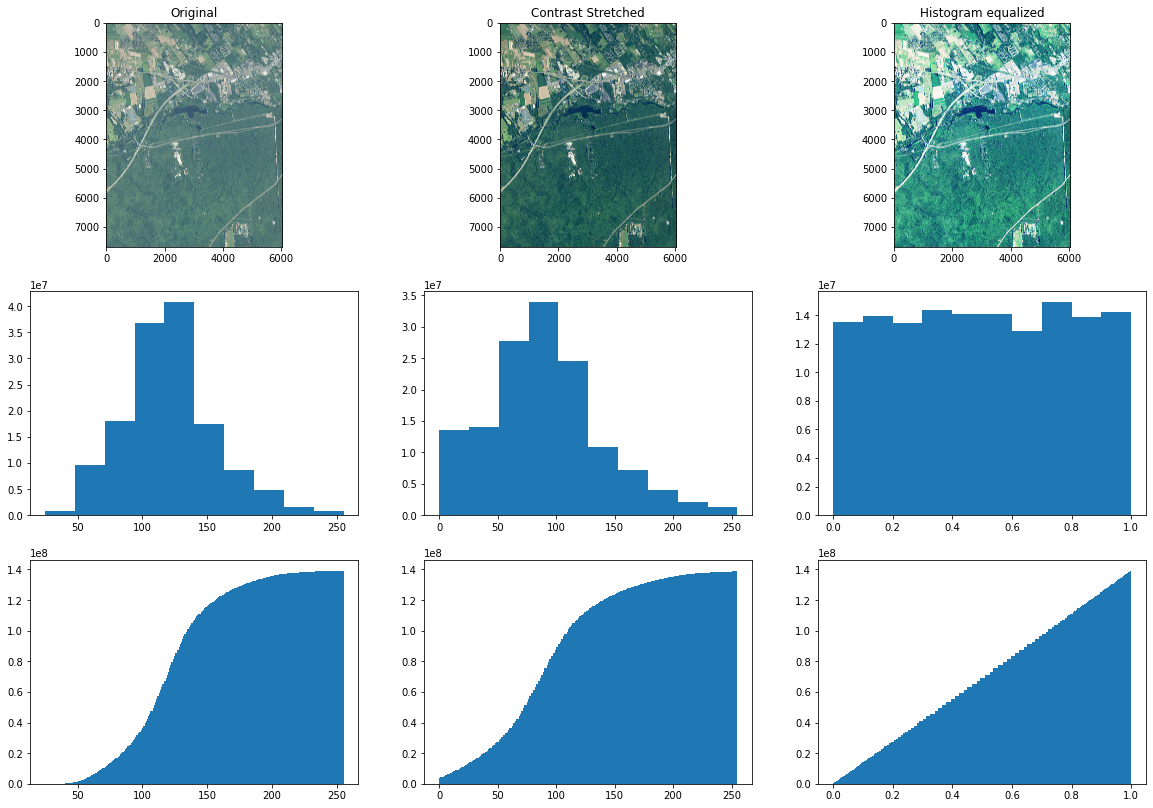

In [21]:
from skimage import exposure

# contrast stretching
# typically, in image data, the top 1 and bottom 1 percent is noise, and not really useful
p2 = np.percentile(rgbnir_array, 2)
p98 = np.percentile(rgbnir_array, 98)
image_ct = exposure.rescale_intensity(rgb_array, in_range=(p2, p98))

# Histogram equalization
image_eq = exposure.equalize_hist(rgb_array)

# set up subplot for images
fig = plt.figure(figsize=(20, 14))

# Subplot for original image
a=fig.add_subplot(3,3,1)
imgplot = plt.imshow(rgb_array)
a.set_title('Original')

# Subplot for contrast stretch image
a=fig.add_subplot(3,3,2)
imgplot = plt.imshow(image_ct)
a.set_title('Contrast Stretched')

# Subplot for equalized stretch image
a=fig.add_subplot(3,3,3)
imgplot = plt.imshow(image_eq)
a.set_title('Histogram equalized')

# Subplots for histograms
a=fig.add_subplot(3,3,4)
imgplot = plt.hist(rgb_array.ravel())

a=fig.add_subplot(3,3,5)
imgplot = plt.hist(image_ct.ravel())

a=fig.add_subplot(3,3,6)
imgplot = plt.hist(image_eq.ravel())

# Subplots for CDF
a = fig.add_subplot(3,3,7)
img_plot = plt.hist(rgb_array.ravel(), bins = 255, cumulative=True)

a = fig.add_subplot(3,3,8)
img_plot = plt.hist(image_ct.ravel(), bins = 255, cumulative=True)

a = fig.add_subplot(3,3,9)
img_plot = plt.hist(image_eq.ravel(), bins = 255, cumulative=True)

plt.show()

## Image Filtering
__Filters can be used to smooth or average the image, sharpen the image, or search for edges__
- Image filters use a kernel, in which each value in the kernel is multiplied by the value in the image underneath it, and then the sum replaces the value at the center of the filter.
- Filters can also be applied to DEMs or others grids, either to enhance trends or to smooth out random noise or generalize the map (such as smoothing a dem to fill sinks for flow accumulation)

[Review Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

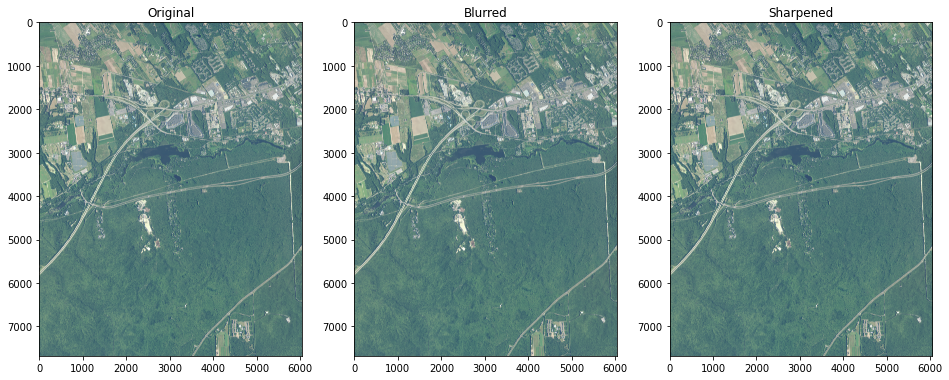

In [36]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

blurred_image = rgb_pil.filter(ImageFilter.BLUR)
sharpened_image = rgb_pil.filter(ImageFilter.SHARPEN)

# Display it
fig = plt.figure(figsize=(16, 12))

# plot original image
a=fig.add_subplot(1,3,1)
img_plot_1 = plt.imshow(rgb_pil)
a.set_title('Original')

# plot blurred image
a=fig.add_subplot(1,3,2)
img_plot_1 = plt.imshow(blurred_image)
a.set_title('Blurred')

# plot sharpened image
a=fig.add_subplot(1,3,3)
img_plot_1 = plt.imshow(sharpened_image)
a.set_title('Sharpened')

plt.show()

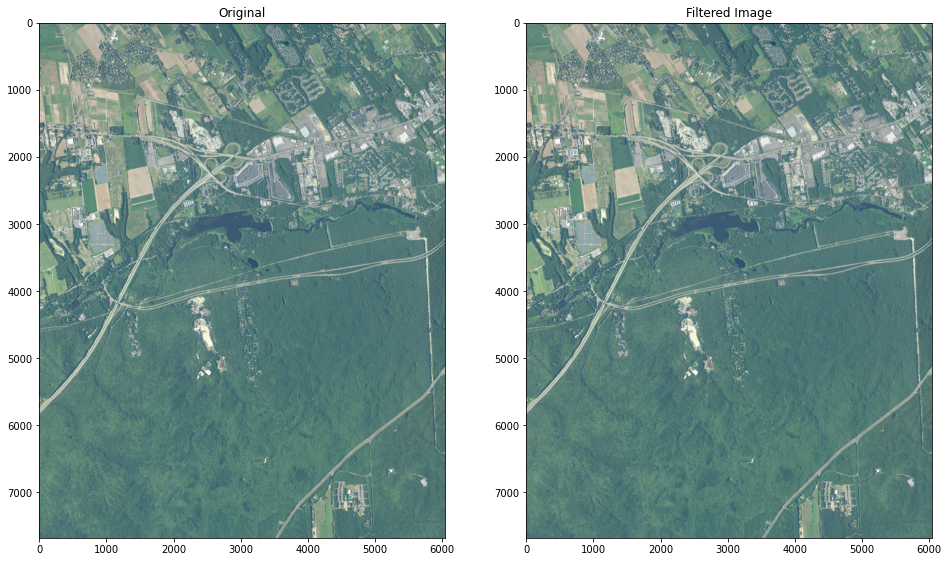

In [39]:
# create your own filter

my_kernel = (200, 50, -100,
            -50, 200, -50,
            -100, 50, 200)

filtered_image = rgb_pil.filter(ImageFilter.Kernel((3,3), my_kernel))

# set up sub plot to display
fig = plt.figure(figsize=(16, 12))

# plot original image
a=fig.add_subplot(1,2,1)
image_plot1 = plt.imshow(rgb_pil)
a.set_title('Original')

# plot filtered image
a=fig.add_subplot(1,2,2)
image_plot2 = plt.imshow(filtered_image)
a.set_title('Filtered Image')

plt.show()

### Edge Detection
Edge detection includes a variety of mathematical methods that aim at identifying points in a digital image at which the image brightness changes sharply or, more formally, has discontinuities ([wiki](https://en.wikipedia.org/wiki/Edge_detection)).

Text(0.5, 1.0, 'Edges Filtered Image')

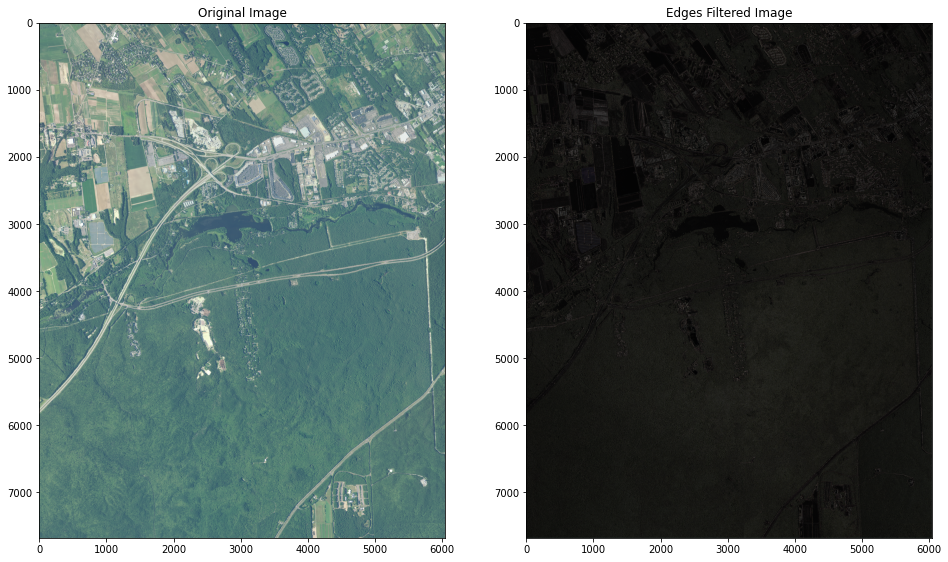

In [40]:
# detect edges of objects using PIL Image FIND_EDGES filter

import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

edges_image = rgb_pil.filter(ImageFilter.FIND_EDGES)

# display it with matplotlib
fig = plt.figure(figsize=(16,12))

# plot original image
a=fig.add_subplot(1,2,1)
img_1 = plt.imshow(rgb_pil)
a.set_title('Original Image')

# plot edge filtered image
a=fig.add_subplot(1,2,2)
img_2 = plt.imshow(edges_image)
a.set_title('Edges Filtered Image')

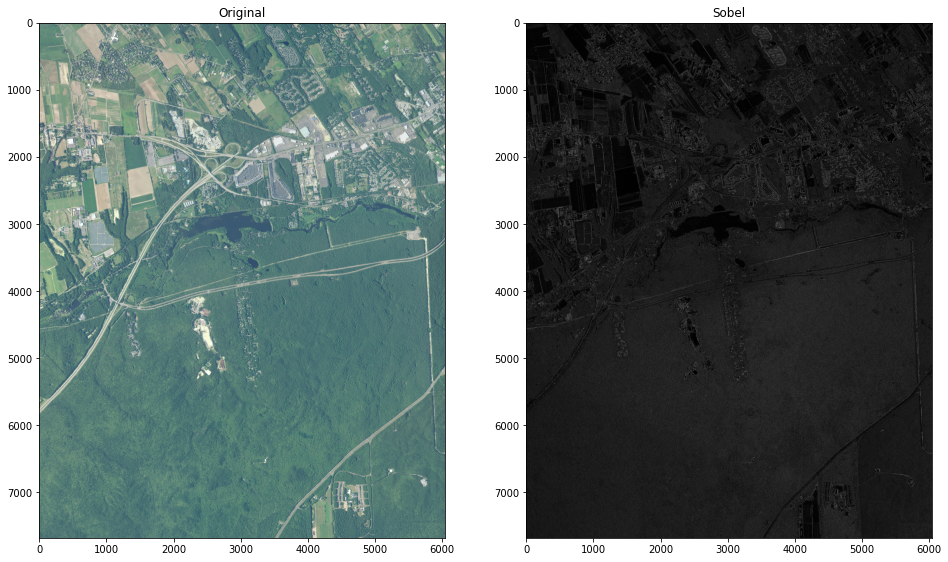

In [41]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude (np.hypot returns the hypotnuse of two "legs" or measurements)
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

sobel_image = edge_sobel(np.array(rgb_pil))

# Display it
fig = plt.figure(figsize=(16, 12))

# Plot original image
a=fig.add_subplot(1, 2, 1)
image_plot_1 = plt.imshow(rgb_pil)
a.set_title("Original")

# Plot Sobel image
a=fig.add_subplot(1, 2, 2)
image_plot_2 = plt.imshow(sobel_image, cmap="gray") # Need to use a gray color map as we converted this to a grayscale image
a.set_title("Sobel")

plt.show()

## Saving Images

In [30]:
## Use the PIL Image object save method
rgb_pil.save('data/rgb_pil.tif', format="Tiff")
# Save the RGB composite with the processed green band
im.save('data/rgb_greenProcessed.tif', format="Tiff")